The first step of preprocessing for the data we are using in class will be cleaning it for initial visualization. The comment bodies will need escape sequences removed, emojis/invalid characters parsed and removed, and any other issues in our data that could prevent a seamless exploration.

In [15]:
#package and data importing and loading
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import warnings
warnings.filterwarnings('ignore')

subreddits = ["kanye", "askScience", "PoliticalDiscussion", "socialism"]

#comments are pulled from the top 40 posts from the past month in each subreddit.
dataframes = []
for sub in subreddits:
    df = pd.read_csv(f"data/comments_{sub}.csv")
    dataframes.append(df)

In [16]:
print(dataframes[0].columns)
for i in range(len(dataframes)):
    print(subreddits[i])
    print(dataframes[i].shape)

Index(['postTag', 'user', 'comment_score', 'comment_body', 'mod_deleted',
       'user_deleted', 'verified', 'is_gold', 'has_verified_email',
       'link_karma', 'total_karma', 'created_utc', 'comment_karma'],
      dtype='object')
kanye
(42654, 13)
askScience
(11134, 13)
PoliticalDiscussion
(31235, 13)
socialism
(3038, 13)


Drop comments that were removed too quickly and so were not archived. Also drop comments automatically generated by mods.

In [17]:
urlRegex = r"(https? *:*\/*\/*)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*"
emptyRegex = r"\[(.*?)\]"
mods = ["https://www.reddit.com/user/AutoModerator", "https://www.reddit.com/user/socialism-ModTeam"]

for i in range(len(dataframes)):
    dataframes[i] = dataframes[i].dropna(subset=["user"])
    dataframes[i] = dataframes[i][~dataframes[i]["user"].isin(mods)]
    for col in ['verified', 'is_gold', 'has_verified_email']:
        dataframes[i][col] = dataframes[i][col].apply(lambda x: 1 if x else 0)
    dataframes[i]['comment_body'] = dataframes[i]['comment_body'].apply(lambda x: re.sub(urlRegex, ' ', x))
    dataframes[i] = dataframes[i][~dataframes[i]["comment_body"].str.contains(emptyRegex)]
    print(subreddits[i])
    print(dataframes[i].shape)

kanye
(40360, 13)
askScience
(6651, 13)
PoliticalDiscussion
(27928, 13)
socialism
(2611, 13)


The distribution of the target is very uneven so we need to make sure we don't overfit on the majority class.


In [18]:
for i in range(len(dataframes)):
    print(subreddits[i])
    print(dataframes[i].groupby(["mod_deleted"]).size())
    print(dataframes[i].groupby(["user_deleted"]).size())
    print()

kanye
mod_deleted
0    39510
1      850
dtype: int64
user_deleted
0    38131
1     2229
dtype: int64

askScience
mod_deleted
0    5121
1    1530
dtype: int64
user_deleted
0    6542
1     109
dtype: int64

PoliticalDiscussion
mod_deleted
0    27092
1      836
dtype: int64
user_deleted
0    27264
1      664
dtype: int64

socialism
mod_deleted
0    2383
1     228
dtype: int64
user_deleted
0    2550
1      61
dtype: int64



Our analysis will be looking at which variables (from the data we collected) are the most useful in classifying whether a comment gets deleted, and if so, whether the user deleted it themselves, or a moderator deleted it. Can we predict based on certain keywords, or a threshold for karma, or any other classifers, what the outcome of the comments status will be? Could this information we use be utilized to enhance the auto moderator currently used on reddit?

The main classifier/variable we are studying will obviously be the comment bodies, as that content will be most critical to parsing the synoposis of messages that routinely get deleted or not. Thus, the data will be mostly free text, with no predefined features. As such, we will use multiple techniques to create training data to be used in model selection and training. Correlations discovered between account creation, comment karma, will be observed but will require less cleaning.

In [20]:
#CountVectorizer 
#We will use CountVectorizer during vectorization of datasets.

comments_trans = []

# Added stemming to vectorization but may not be necessary, max_df has a bigger impact
porter = SnowballStemmer("english")
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

for i in range(len(dataframes)):
    comments = dataframes[i]["comment_body"].apply(lambda x: " ".join(tokenizer_porter(x)))
    vect = CountVectorizer(stop_words=stopwords.words('english'),max_df=.5, ngram_range=(1,2) ,max_features=50, strip_accents="unicode")
    vect.fit(comments)
    print(subreddits[i])
    print(vect.get_feature_names_out())
    print()
    comments_trans.append(vect.transform(comments).toarray())
    vect = CountVectorizer(stop_words=stopwords.words('english'),max_df=.5, ngram_range=(2,2) ,max_features=25, strip_accents="unicode")
    vect.fit(comments)
    print(vect.get_feature_names_out())
    print()


kanye
['actual' 'also' 'ani' 'anti' 'becaus' 'black' 'call' 'even' 'fuck' 'get'
 'go' 'good' 'hate' 'jew' 'jewish' 'kany' 'know' 'like' 'lol' 'make' 'man'
 'mean' 'music' 'need' 'one' 'onli' 'peopl' 'person' 'point' 'realli'
 'right' 'said' 'say' 'see' 'shit' 'someon' 'still' 'take' 'talk' 'thing'
 'think' 'time' 'tri' 'use' 'want' 'way' 'whi' 'white' 'would' 'ye']

['act like' 'anti semit' 'black peopl' 'black people' 'death con'
 'eric andr' 'feel like' 'georg floyd' 'get help' 'jewish peopl'
 'jewish people' 'kany said' 'kany west' 'like kany' 'look like'
 'mental health' 'mental ill' 'need help' 'peopl like' 'piec shit'
 'seem like' 'social media' 'sound like' 'white peopl' 'year old']

askScience
['actual' 'also' 'ani' 'becaus' 'bodi' 'caus' 'cell' 'could' 'differ'
 'doe' 'earth' 'effect' 'enough' 'even' 'get' 'go' 'human' 'know' 'like'
 'long' 'look' 'lot' 'make' 'mani' 'mean' 'much' 'need' 'one' 'onli'
 'peopl' 'pressur' 'realli' 'say' 'see' 'someth' 'still' 'system' 'take'
 'th

In [21]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer
x = ['postTag', 'comment_body', 'comment_score', 'verified', 'is_gold', 'has_verified_email',
       'link_karma', 'total_karma', 'created_utc', 'comment_karma']
y = "mod_deleted"
x_cont = x[2:]
x_text = 'comment_body'


training before resampling: mod_deleted
0    28899
1      466
dtype: int64
kanye
Best Training Score: 0.579153363786477, Best Params: {'vect__use_idf': True, 'vect__tokenizer': None, 'vect__strip_accents': None, 'vect__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over

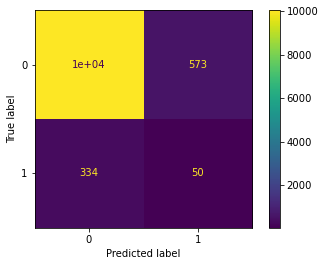


training before resampling: mod_deleted
0    3416
1     809
dtype: int64
askScience
Best Training Score: 0.6232209499681971, Best Params: {'vect__use_idf': True, 'vect__tokenizer': None, 'vect__strip_accents': None, 'vect__stop_words': None, 'vect__norm': 'l1', 'vect__ngram_range': (1, 12), 'vect__max_features': None, 'vect__max_df': 0.5, 'clf__solver': 'sag', 'clf__alpha': 0.0031622776601683794}
Test Score: 0.5774938169826875
Test set size mod_deleted
0    1705
1     721
Name: mod_deleted, dtype: int64


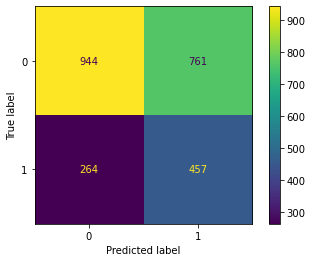


training before resampling: mod_deleted
0    16739
1      559
dtype: int64
PoliticalDiscussion
Best Training Score: 0.6414400938922109, Best Params: {'vect__use_idf': True, 'vect__tokenizer': None, 'vect__strip_accents': None, 'vect__stop_words': None, 'vect__norm': 'l1', 'vect__ngram_range': (1, 12), 'vect__max_features': None, 'vect__max_df': 0.5, 'clf__solver': 'sparse_cg', 'clf__alpha': 0.0031622776601683794}
Test Score: 0.8423330197554092
Test set size mod_deleted
0    10353
1      277
Name: mod_deleted, dtype: int64


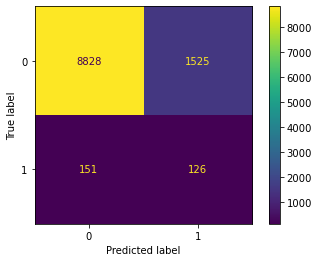


training before resampling: mod_deleted
0    1524
1     141
dtype: int64
socialism
Best Training Score: 0.5793508409374268, Best Params: {'vect__use_idf': True, 'vect__tokenizer': None, 'vect__strip_accents': 'ascii', 'vect__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off'

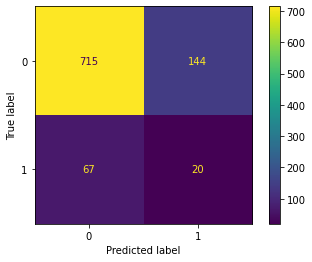

In [29]:
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import ConfusionMatrixDisplay

#y is our target, what we are trying to predict. That is either deleted by mod or deleted by user (if deleted at all). Two splits.
for i in range(len(dataframes)):
    df = dataframes[i]
    tfidf = TfidfVectorizer()
    # Use grouped split so that comments from a posts are not split between training & test set
    X = df[x]
    Y = df[y]
    Y = Y.apply(lambda x: "1" if x else "0")
    gs = GroupShuffleSplit(n_splits=2, test_size=.3, random_state=0)
    train_ind, test_ind = next(gs.split(X, Y, groups=X.postTag))
    X_test = X.iloc[test_ind].drop("postTag", axis=1)
    y_test = Y.iloc[test_ind]
    # Duplicate minority class to match majority class to avoid overfitting
    X_train = X.iloc[train_ind]
    
    y_train = Y.iloc[train_ind]
    train = pd.concat([X_train, y_train], axis=1)
    print(f"training before resampling: {train.groupby(by=train[y]).size()}")
    root = [train]
    size = train[y].value_counts().max()
    for class_index, group in train.groupby(y):
        root.append(group.sample(size-len(group), replace=True))
    train = pd.concat(root)
    X_train = train[x_text]
    y_train = train[y]
    
    # Create model pipeline & param_grids
    param_grid = ({'vect__ngram_range': [(1,1), (2,2), (3,3), (4,4), (5,5), (1,4), (1,8), (1,12)],
                   'vect__stop_words': [stopwords.words('english'), None],
                   'vect__tokenizer': [None],
                   'vect__max_features': [None, 25, 50, 75, 100],
                   'vect__use_idf': [True, False],
                   'vect__max_df': np.arange(.4, .9, .05),
                   'vect__norm': ['l1', 'l2'],
                   'vect__strip_accents': ['ascii', None],
                   'clf__alpha': np.logspace(-4,2,5),
                   'clf__solver': ["sparse_cg", "sag"]
                  })
    pipeline = Pipeline([('vect', tfidf),
                        ('clf', RidgeClassifier(max_iter=100000))])
    gss = GroupShuffleSplit(test_size=.3)
    
    grid = RandomizedSearchCV(estimator=pipeline,n_iter=100,n_jobs=-1, param_distributions=param_grid, return_train_score=True, 
                             cv=gss)
    grid.fit(X_train, y_train, groups=train["postTag"])
    print(subreddits[i])
    print(f"Best Training Score: {grid.best_score_}, Best Params: {grid.best_params_}")
    print(f"Test Score: {grid.score(X_test[x_text], y_test)}")
    print(f"Test set size {y_test.groupby(y_test).size()}")
    model = grid.best_estimator_
    y_pred = model.predict(X_test[x_text])
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    print()

training before resampling: mod_deleted
0    28899
1      466
dtype: int64
kanye
Test set size mod_deleted
0    10611
1      384
Name: mod_deleted, dtype: int64
Best Training Score: 0.5463626224186843, Best Params: {'vect__use_idf': False, 'vect__tokenizer': None, 'vect__strip_accents': None, 'vect__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'aft

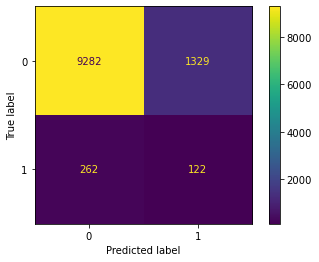


training before resampling: mod_deleted
0    3416
1     809
dtype: int64
askScience
Test set size mod_deleted
0    1705
1     721
Name: mod_deleted, dtype: int64
Best Training Score: 0.593102039032981, Best Params: {'vect__use_idf': False, 'vect__tokenizer': None, 'vect__strip_accents': 'ascii', 'vect__stop_words': None, 'vect__norm': 'l1', 'vect__ngram_range': (1, 4), 'vect__max_features': 75, 'vect__max_df': 0.6499999999999999, 'clf__n_estimators': 400}
Test Score: 0.6265457543281121


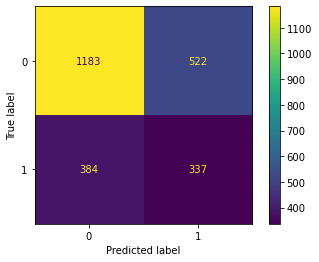


training before resampling: mod_deleted
0    16739
1      559
dtype: int64
PoliticalDiscussion
Test set size mod_deleted
0    10353
1      277
Name: mod_deleted, dtype: int64
Best Training Score: 0.6491689164901222, Best Params: {'vect__use_idf': False, 'vect__tokenizer': None, 'vect__strip_accents': 'ascii', 'vect__stop_words': None, 'vect__norm': 'l1', 'vect__ngram_range': (1, 1), 'vect__max_features': 25, 'vect__max_df': 0.8499999999999999, 'clf__n_estimators': 200}
Test Score: 0.6840075258701788


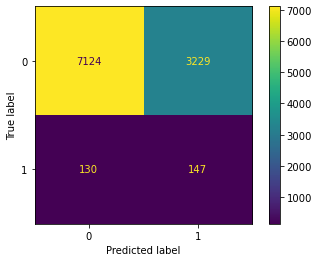


training before resampling: mod_deleted
0    1524
1     141
dtype: int64
socialism
Test set size mod_deleted
0    859
1     87
Name: mod_deleted, dtype: int64
Best Training Score: 0.558260920672171, Best Params: {'vect__use_idf': False, 'vect__tokenizer': None, 'vect__strip_accents': None, 'vect__stop_words': None, 'vect__norm': 'l1', 'vect__ngram_range': (1, 12), 'vect__max_features': 75, 'vect__max_df': 0.8999999999999999, 'clf__n_estimators': 50}
Test Score: 0.587737843551797


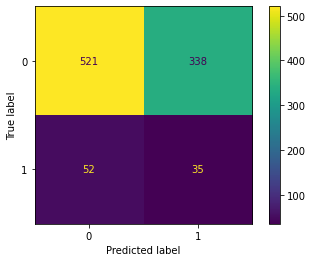

In [31]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import ConfusionMatrixDisplay

#y is our target, what we are trying to predict. That is either deleted by mod or deleted by user (if deleted at all). Two splits.
for i in range(len(dataframes)):
    df = dataframes[i]
    tfidf = TfidfVectorizer()
    # Use grouped split so that comments from a posts are not split between training & test set
    X = df[x]
    Y = df[y]
    Y = Y.apply(lambda x: "1" if x else "0")
    gs = GroupShuffleSplit(n_splits=2, test_size=.3, random_state=0)
    train_ind, test_ind = next(gs.split(X, Y, groups=X.postTag))
    X_test = X.iloc[test_ind].drop("postTag", axis=1)
    y_test = Y.iloc[test_ind]
    # Duplicate minority class to match majority class to avoid overfitting
    X_train = X.iloc[train_ind]
    
    y_train = Y.iloc[train_ind]
    train = pd.concat([X_train, y_train], axis=1)
    print(f"training before resampling: {train.groupby(by=train[y]).size()}")
    root = [train]
    size = train[y].value_counts().max()
    for class_index, group in train.groupby(y):
        root.append(group.sample(size-len(group), replace=True))
    train = pd.concat(root)
    X_train = train[x_text]
    y_train = train[y]
    
    # Create model pipeline & param_grids
    param_grid = ({'vect__ngram_range': [(1,1), (2,2), (3,3), (4,4), (5,5), (1,4), (1,8), (1,12)],
                   'vect__stop_words': [stopwords.words('english'), None],
                   'vect__tokenizer': [None],
                   'vect__max_features': [None, 25, 50, 75, 100],
                   'vect__use_idf': [True, False],
                   'vect__max_df': np.arange(.3, .9, .05),
                   'vect__norm': ['l1', 'l2'],
                   'vect__strip_accents': ['ascii', None],
                   'clf__n_estimators': np.arange(50 ,500,50),
                  })
    pipeline = Pipeline([('vect', tfidf),
                        ('clf', AdaBoostClassifier(algorithm="SAMME"))])
    
    grid = RandomizedSearchCV(estimator=pipeline,n_iter=100,n_jobs=-1, param_distributions=param_grid, return_train_score=True, 
                             cv=gss)
    gss = GroupShuffleSplit(test_size=.3)
    grid.fit(X_train, y_train, groups=train["postTag"])
    print(subreddits[i])
    print(f"Test set size {y_test.groupby(y_test).size()}")
    print(f"Best Training Score: {grid.best_score_}, Best Params: {grid.best_params_}")
    print(f"Test Score: {grid.score(X_test[x_text], y_test)}")
    model = grid.best_estimator_
    y_pred = model.predict(X_test[x_text])
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    print()